In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "M-type_MADS"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn002551,MKRIENATSRQVTFSKRRNGLLKKAFELSVLCDAEVALIIFSNKGR...,126,1
1,Achn015591,MGRSVKHESITNERVRRQTFQKRKAGLFKKVSELQTLCGHDACAVI...,165,1
2,Achn041671,MAREKIKIKKIDNITARQVTFSKRRRGLFKKAEELAVLCDAEVALI...,93,1
3,Achn041761,MGRGKIVIRRIDNSTSRQVTFSKRRNGLLKKAKELAILCDAEVGVI...,91,1
4,Achn058181,MTRNKINLALIANESSRKATLKKRRASMFKKIEELSVLSDVRTGAI...,253,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
9904,0.008850,0.000000,0.000000,0.000000,0.00000,0.00000,0.008850,0.000000,0.008850,0.000000,...,0.000000,0.000000,0.008850,0.008850,0.000000,0.000000,0.0,0.000000,0.0,0.000000
11310,0.011628,0.002326,0.002326,0.002326,0.00000,0.00000,0.004651,0.000000,0.002326,0.004651,...,0.004651,0.002326,0.000000,0.000000,0.002326,0.000000,0.0,0.002326,0.0,0.000000
446,0.000000,0.003040,0.003040,0.000000,0.00304,0.00304,0.000000,0.000000,0.000000,0.009119,...,0.003040,0.006079,0.000000,0.000000,0.009119,0.003040,0.0,0.000000,0.0,0.003040
1633,0.000000,0.000000,0.006098,0.000000,0.00000,0.00000,0.006098,0.006098,0.006098,0.006098,...,0.000000,0.000000,0.000000,0.000000,0.006098,0.000000,0.0,0.000000,0.0,0.000000
7295,0.006803,0.000000,0.006803,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006803,0.006803,0.000000,0.006803,0.0,0.000000,0.0,0.006803


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (12040, 441)
X_test: (3011, 441)
y_train: (12040,)
y_test: (3011,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1:34 630ms/step - accuracy: 0.5000 - loss: 0.6931

 27/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5380 - loss: 0.6887    

 54/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5932 - loss: 0.6671

 83/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6450 - loss: 0.6230

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6799 - loss: 0.5830

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7069 - loss: 0.5480

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7216 - loss: 0.5279 - val_accuracy: 0.9406 - val_loss: 0.1546


Epoch 2/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9531 - loss: 0.1147

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9418 - loss: 0.1601 

 44/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9444 - loss: 0.1555

 67/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9466 - loss: 0.1507

 90/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9477 - loss: 0.1487

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9481 - loss: 0.1480

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9482 - loss: 0.1473

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9481 - loss: 0.1473 - val_accuracy: 0.9277 - val_loss: 0.1955


Epoch 3/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9531 - loss: 0.1378

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9513 - loss: 0.1338 

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9545 - loss: 0.1266

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9554 - loss: 0.1256

 98/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1267

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9547 - loss: 0.1277

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1287

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1290 - val_accuracy: 0.9518 - val_loss: 0.1325


Epoch 4/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9375 - loss: 0.1859

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9570 - loss: 0.1398 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1277

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1231

 95/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1237

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1242

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9581 - loss: 0.1244

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1244 - val_accuracy: 0.9464 - val_loss: 0.1504


Epoch 5/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0768

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9616 - loss: 0.1188 

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.1118

 69/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9645 - loss: 0.1077

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9649 - loss: 0.1058

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9652 - loss: 0.1045

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9651 - loss: 0.1043

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9649 - loss: 0.1046 - val_accuracy: 0.9556 - val_loss: 0.1299


Epoch 6/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9375 - loss: 0.1941

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9525 - loss: 0.1260 

 47/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1168

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9608 - loss: 0.1109

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9627 - loss: 0.1069

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9635 - loss: 0.1053

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.1041

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9643 - loss: 0.1035 - val_accuracy: 0.9618 - val_loss: 0.1171


Epoch 7/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0305

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9795 - loss: 0.0696 

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9750 - loss: 0.0789

 76/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9721 - loss: 0.0850

100/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.0873

125/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9708 - loss: 0.0876

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9708 - loss: 0.0874

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9708 - loss: 0.0873 - val_accuracy: 0.9568 - val_loss: 0.1164


Epoch 8/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0439

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.0687 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0654

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0652

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9776 - loss: 0.0661

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0664

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0667

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0668 - val_accuracy: 0.9572 - val_loss: 0.1226


Epoch 9/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0469

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.0669 

 47/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9804 - loss: 0.0659

 69/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0639

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0624

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0614

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.0605

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 0.0599 - val_accuracy: 0.9635 - val_loss: 0.1061


Epoch 10/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0134

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0404 

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9809 - loss: 0.0544

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.0606

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0614

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 0.0610

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0607

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9775 - loss: 0.0606 - val_accuracy: 0.9647 - val_loss: 0.1091


Epoch 11/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0761

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0342 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0371

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0387

 95/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0403

118/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0411

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0416

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0418 - val_accuracy: 0.9593 - val_loss: 0.1508


Epoch 12/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0503

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0383 

 47/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0385

 69/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0371

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0364

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0359

139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0355

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0354 - val_accuracy: 0.9664 - val_loss: 0.1051


Epoch 13/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0111

 21/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0233 

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0251

 68/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0259

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0258

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0255

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0251

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0250 - val_accuracy: 0.9701 - val_loss: 0.1115


Epoch 14/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0025

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0297 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0273

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0259

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0252

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0248

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0246

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0247 - val_accuracy: 0.9684 - val_loss: 0.1134


Epoch 15/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0025

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0322 

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0297

 68/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0274

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0258

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0254

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0252

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0252 - val_accuracy: 0.9639 - val_loss: 0.1536


Epoch 16/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0261

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0244 

 47/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0246

 70/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0245

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0245

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0241

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0241

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0241 - val_accuracy: 0.9705 - val_loss: 0.1328


Epoch 17/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0020

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0049 

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0089

 74/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0116

 98/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0135

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0149

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0163

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0164 - val_accuracy: 0.9655 - val_loss: 0.1444


Epoch 18/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0173

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0133 

 45/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0153

 69/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0162

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0162

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0165

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0168

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0169 - val_accuracy: 0.9680 - val_loss: 0.1246


Epoch 19/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0354

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0179 

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0147

 75/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0134

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0130

118/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0127

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0127

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0128 - val_accuracy: 0.9713 - val_loss: 0.1257


Epoch 20/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0162

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0135 

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0119

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0111

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0107

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0104

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0102

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0101 - val_accuracy: 0.9697 - val_loss: 0.1530


Epoch 21/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 4.1450e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0071     

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0083

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0082

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0082

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0084

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0087

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.9734 - val_loss: 0.1248


Epoch 22/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0045

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0119 

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0132

 70/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0131

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0132

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0136

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0137

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0137 - val_accuracy: 0.9630 - val_loss: 0.1644


Epoch 23/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0013

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0089 

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0080

 67/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0080

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0079

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0081

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0093

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0100 - val_accuracy: 0.9676 - val_loss: 0.1325


Epoch 24/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0062

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0107 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0109

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0106

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0106

118/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0106

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0105

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0106 - val_accuracy: 0.9713 - val_loss: 0.1387


Epoch 25/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0011

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0216 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0172

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0149

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0137

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0136

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0136

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0136 - val_accuracy: 0.9705 - val_loss: 0.1199


Epoch 26/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0028

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0066 

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0087

 68/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0094

 91/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0108

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0132

139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0147

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0151 - val_accuracy: 0.9705 - val_loss: 0.1173


Epoch 27/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0065

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0049 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0055

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0054

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0054

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0053

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0052

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9743 - val_loss: 0.1318


Epoch 28/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0011

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0053 

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0052

 68/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0049

 90/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0045

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0043

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0044

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0047 - val_accuracy: 0.9713 - val_loss: 0.1353


Epoch 29/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 9.6477e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0046     

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0052

 70/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0054

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0055

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0061

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0068

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0071 - val_accuracy: 0.9697 - val_loss: 0.1436


Epoch 30/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0221

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0051 

 52/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0038

 76/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0035

101/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0033

126/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0033

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0033

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0033 - val_accuracy: 0.9693 - val_loss: 0.1515


Epoch 31/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0159

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0269 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0238

 70/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0213

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0191

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0175

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0163

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0157 - val_accuracy: 0.9751 - val_loss: 0.1235


Epoch 32/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 3.6967e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0038     

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0040

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0045

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0051

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0058

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0064

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0065 - val_accuracy: 0.9701 - val_loss: 0.1509


Epoch 33/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0011

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0170 

 45/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0149

 68/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0128

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0113

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0107

139/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0103

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0101 - val_accuracy: 0.9734 - val_loss: 0.1355


Epoch 34/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0021

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0052 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0054

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0053

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0054

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0055

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0059

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0061 - val_accuracy: 0.9722 - val_loss: 0.1365


Epoch 35/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.2093e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0190     

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0175

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0160

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0148

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0141

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0139

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0139 - val_accuracy: 0.9713 - val_loss: 0.1408


Epoch 36/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0014

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0152 

 47/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0155

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0149

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0140

117/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0131

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0125

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0122 - val_accuracy: 0.9747 - val_loss: 0.1400


Epoch 37/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.2872e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.6201e-04 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.9432e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 9.3873e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0012    

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0015

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0017

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9718 - val_loss: 0.1732


Epoch 38/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0023

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0023 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0048

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0064

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0072

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0077

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0078

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0079 - val_accuracy: 0.9726 - val_loss: 0.1277


Epoch 39/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0162

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0034 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0025

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0023

 95/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0022

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0024

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0028

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0030 - val_accuracy: 0.9726 - val_loss: 0.1640


Epoch 40/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0097

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0110 

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0106

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0099

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0093

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0088

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0083

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0082 - val_accuracy: 0.9709 - val_loss: 0.1517


Epoch 41/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 4.9197e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014     

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0015

 74/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0014

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0014

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0014

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9763 - val_loss: 0.1464


Epoch 42/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.3978e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014     

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0013

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0018

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0020

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0021

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9743 - val_loss: 0.1556


Epoch 43/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 2.1176e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.1631e-04 

 45/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0024    

 69/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0034

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0058

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0091

140/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0114

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0121 - val_accuracy: 0.9722 - val_loss: 0.1212


Epoch 44/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0014

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0089 

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0071

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0065

 95/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0061

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0057

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0054

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0053 - val_accuracy: 0.9734 - val_loss: 0.1463


Epoch 45/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0134

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0049 

 45/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0064

 69/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0067

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0066

118/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0066

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0067

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0068 - val_accuracy: 0.9747 - val_loss: 0.1363


Epoch 46/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.8150e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0061     

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0067

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0086

 95/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0094

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0095

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0094

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0093 - val_accuracy: 0.9718 - val_loss: 0.1601


Epoch 47/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.8620e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0013     

 47/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0016

 70/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0015

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0015

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0017

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0018

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9743 - val_loss: 0.1511


Epoch 48/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 3.0996e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.1417e-04 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.1351e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.5234e-04

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.8997e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.3629e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 5.5236e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 5.5412e-04 - val_accuracy: 0.9734 - val_loss: 0.1683


Epoch 49/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 7.2230e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7128e-04 

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 8.3096e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 7.8267e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 7.3024e-04

112/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 7.4243e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 9.7825e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9639 - val_loss: 0.1962


Epoch 50/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0039

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0048 

 46/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0046

 70/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0046

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0050

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0058

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0065

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0068 - val_accuracy: 0.9643 - val_loss: 0.1834


Epoch 51/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0019

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0028 

 48/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0037

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0044

 96/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0047

119/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0050

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0051

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0052 - val_accuracy: 0.9585 - val_loss: 0.2785



[Train Accuracy: 99.74% - Test Accuracy: 95.68%]


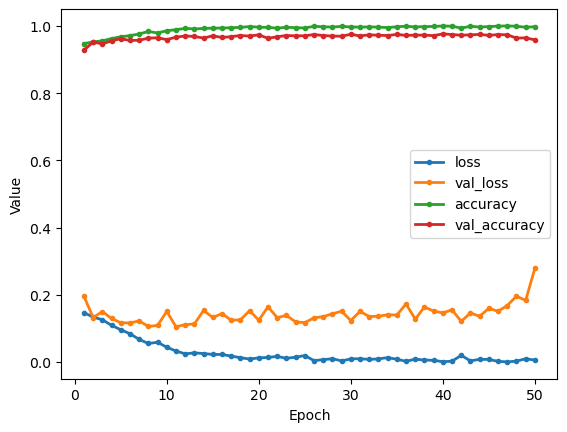

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
9904,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,0.002331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002331,0.002331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1633,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7295,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (12040, 9013)
X_test: (3011, 9013)
y_train: (12040,)
y_test: (3011,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,307,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,350,849 (8.97 MB)

 Trainable params: 2,350,849 (8.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2:12 885ms/step - accuracy: 0.4062 - loss: 0.6932

  7/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4437 - loss: 0.6933    

 14/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4731 - loss: 0.6930

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4961 - loss: 0.6924

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5268 - loss: 0.6913

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5548 - loss: 0.6893

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5796 - loss: 0.6856

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6015 - loss: 0.6798

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6212 - loss: 0.6717

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6390 - loss: 0.6619

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6550 - loss: 0.6510

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6693 - loss: 0.6392

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6823 - loss: 0.6270

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6940 - loss: 0.6147

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7047 - loss: 0.6023

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7145 - loss: 0.5901

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7236 - loss: 0.5781

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7321 - loss: 0.5664

127/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7400 - loss: 0.5551

134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7473 - loss: 0.5441

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7542 - loss: 0.5335

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7606 - loss: 0.5233

151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7641 - loss: 0.5176 - val_accuracy: 0.9859 - val_loss: 0.0511


Epoch 2/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0184

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9981 - loss: 0.0202 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9951 - loss: 0.0251

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9933 - loss: 0.0277

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.0293

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9917 - loss: 0.0297

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9914 - loss: 0.0297

 49/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9912 - loss: 0.0298

 56/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9911 - loss: 0.0298

 63/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0297

 70/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0296

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0294

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0293

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0293

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9909 - loss: 0.0293

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9909 - loss: 0.0294

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0295

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0295

127/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0295

134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0296

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0296

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0297

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9908 - loss: 0.0298 - val_accuracy: 0.9842 - val_loss: 0.0512


Epoch 3/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0069

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9983 - loss: 0.0109 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9980 - loss: 0.0113

 23/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 0.0109

 30/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9979 - loss: 0.0104

 38/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 0.0099

 45/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 0.0095

 52/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 0.0092

 59/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0089

 66/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0086

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0083

 81/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0080

 88/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0078

 95/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0076

102/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0075

109/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0073

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0072

123/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0071

131/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0070

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0070

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0070

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9985 - loss: 0.0069 - val_accuracy: 0.9821 - val_loss: 0.0714


Epoch 4/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 9.4122e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0019     

 15/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0021

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0024

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0026

 37/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0026

 44/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0026

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0027

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0027

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0028

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0029

 79/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0030

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0030

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0030

 97/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

101/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

129/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0030

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9850 - val_loss: 0.0690


Epoch 5/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 3.8124e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.5887e-04 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010    

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9223e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6564e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4440e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.2852e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1879e-04

 79/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1092e-04

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0185e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9558e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8801e-04

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7880e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6856e-04

124/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6185e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5668e-04

138/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5067e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4404e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.3690e-04 - val_accuracy: 0.9875 - val_loss: 0.0655


Epoch 6/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 3.3274e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.2098e-04 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0751e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9588e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0968e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1555e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1744e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1697e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1604e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1415e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1200e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1083e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1378e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1671e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1857e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1962e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2022e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2043e-04

127/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2033e-04

134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1987e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1909e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2404e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.4079e-04 - val_accuracy: 0.9871 - val_loss: 0.0731


Epoch 7/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 7.5466e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.9737e-05 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2540e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5879e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0014    

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0018

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0020

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0021

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0021

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0021

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0021

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0020

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0020

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0020

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0019

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0019

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0018

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0018

127/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0018

134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0017

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0017

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0017

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9859 - val_loss: 0.0735


Epoch 8/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 2.2763e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.6950e-05 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9232e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9756e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0800e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0582e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4016e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6264e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7770e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8651e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8997e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2329e-04

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1997e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 3.1001e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 3.8902e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 4.5213e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.0309e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.4483e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.7914e-04

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.0739e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.3025e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.4894e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 6.5595e-04 - val_accuracy: 0.9859 - val_loss: 0.0734


Epoch 9/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 2.7030e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.3070e-04 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0924e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0057e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3591e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8839e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6765e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5390e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4143e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2784e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2691e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5797e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5946e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3958e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.0161e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 5.5048e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.1059e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 6.7404e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 7.3274e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 7.8202e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 8.1775e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 8.4833e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 8.5626e-04 - val_accuracy: 0.9859 - val_loss: 0.0719


Epoch 10/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 1.2298e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.6353e-05 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.0481e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0150e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0769e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0998e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1096e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1104e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1009e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0902e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0790e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0669e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0534e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0683e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0881e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1097e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1283e-04

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1410e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1486e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1535e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1560e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1572e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1573e-04 - val_accuracy: 0.9859 - val_loss: 0.0784


Epoch 11/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 2.1732e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0731e-04 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.4652e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3952e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7900e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.4051e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.1250e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9044e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.7362e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.6089e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5100e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4166e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3354e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2599e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1890e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1320e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0805e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0298e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9796e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9353e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8916e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8623e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.8460e-05 - val_accuracy: 0.9871 - val_loss: 0.0825


Epoch 12/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 2.0551e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.5179e-05 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.6365e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1073e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3884e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5481e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6429e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6949e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7344e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7445e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7474e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7426e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7422e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7335e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7260e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7117e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7006e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6928e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6820e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6671e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6490e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6299e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.6244e-05 - val_accuracy: 0.9871 - val_loss: 0.0860


Epoch 13/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 6.3622e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.3891e-05 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5633e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8015e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1057e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2496e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3128e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3430e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3720e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3847e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3888e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3857e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3851e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3918e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3917e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3892e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3848e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3771e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3705e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3626e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3537e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3442e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.3428e-05 - val_accuracy: 0.9871 - val_loss: 0.0887


Epoch 14/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 5.0942e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1235e-05 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2235e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3699e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5572e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6353e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6662e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6819e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6874e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6935e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7008e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7000e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6951e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6897e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6882e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6874e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6842e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6798e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6739e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6759e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6772e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6771e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.6769e-05 - val_accuracy: 0.9867 - val_loss: 0.0910


Epoch 15/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 2.5769e-06

  8/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.7955e-06 

 15/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0422e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0246e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0086e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0243e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0355e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0448e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0539e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0590e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0684e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0759e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0816e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0861e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0905e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0930e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0935e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0932e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0924e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0905e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0880e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0910e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0919e-05 - val_accuracy: 0.9871 - val_loss: 0.0931



[Train Accuracy: 100.00% - Test Accuracy: 98.47%]


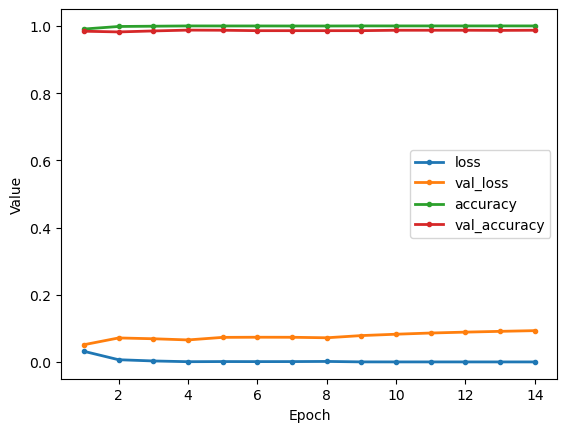

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

47/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

43/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
9904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      40,663,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,704,513 (155.28 MB)

 Trainable params: 40,704,513 (155.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 2:16 912ms/step - accuracy: 0.6094 - loss: 0.6931

  2/151 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.5742 - loss: 0.6932 

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.5582 - loss: 0.6932

  4/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5524 - loss: 0.6931

  5/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.5519 - loss: 0.6930

  6/151 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5507 - loss: 0.6930

  7/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.5504 - loss: 0.6928

  8/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.5493 - loss: 0.6928

  9/151 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.5474 - loss: 0.6927

 10/151 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.5455 - loss: 0.6927

 11/151 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.5433 - loss: 0.6927

 12/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.5413 - loss: 0.6927

 13/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.5397 - loss: 0.6926

 14/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.5386 - loss: 0.6926

 15/151 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.5375 - loss: 0.6925

 16/151 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.5367 - loss: 0.6924

 17/151 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.5361 - loss: 0.6923

 18/151 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.5355 - loss: 0.6922

 19/151 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.5350 - loss: 0.6920

 20/151 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.5343 - loss: 0.6919

 21/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.5338 - loss: 0.6918

 22/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.5334 - loss: 0.6916

 23/151 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.5328 - loss: 0.6915

 24/151 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.5324 - loss: 0.6913

 25/151 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.5319 - loss: 0.6911

 26/151 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.5315 - loss: 0.6909

 27/151 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.5310 - loss: 0.6907

 28/151 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5307 - loss: 0.6904

 29/151 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.5302 - loss: 0.6902

 30/151 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.5299 - loss: 0.6899

 31/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5299 - loss: 0.6896

 32/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5301 - loss: 0.6893

 33/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5305 - loss: 0.6890

 34/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5311 - loss: 0.6886

 35/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5318 - loss: 0.6882

 36/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5326 - loss: 0.6878

 37/151 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5335 - loss: 0.6873

 38/151 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5343 - loss: 0.6868

 39/151 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5352 - loss: 0.6863

 40/151 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5362 - loss: 0.6857

 41/151 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5372 - loss: 0.6851

 42/151 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5384 - loss: 0.6845

 43/151 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5398 - loss: 0.6839

 44/151 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5413 - loss: 0.6832

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.5429 - loss: 0.6824

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.5445 - loss: 0.6817

 47/151 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5463 - loss: 0.6809

 48/151 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5480 - loss: 0.6801

 49/151 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.5498 - loss: 0.6792

 50/151 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5516 - loss: 0.6783

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.5535 - loss: 0.6774

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.5555 - loss: 0.6764

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.5574 - loss: 0.6754

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.5594 - loss: 0.6744

 55/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.5614 - loss: 0.6734

 56/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.5635 - loss: 0.6723

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.5655 - loss: 0.6712

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5676 - loss: 0.6700

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5697 - loss: 0.6688

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5717 - loss: 0.6676

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5738 - loss: 0.6663

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5759 - loss: 0.6650

 63/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5780 - loss: 0.6637

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5800 - loss: 0.6624

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5821 - loss: 0.6610

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5842 - loss: 0.6597

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 0.5863 - loss: 0.6582

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.5883 - loss: 0.6568

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.5904 - loss: 0.6553

 70/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.5924 - loss: 0.6538

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.5944 - loss: 0.6524

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.5964 - loss: 0.6508

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.5984 - loss: 0.6493

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.6004 - loss: 0.6478

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.6024 - loss: 0.6462

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.6043 - loss: 0.6446

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6063 - loss: 0.6430

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6082 - loss: 0.6413

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6101 - loss: 0.6397

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6120 - loss: 0.6380

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6139 - loss: 0.6364

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6158 - loss: 0.6347

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6176 - loss: 0.6330

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.6195 - loss: 0.6312 

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.6213 - loss: 0.6295

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.6231 - loss: 0.6277

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.6249 - loss: 0.6260

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.6267 - loss: 0.6242

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.6285 - loss: 0.6225

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.6302 - loss: 0.6207

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6320 - loss: 0.6189

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6337 - loss: 0.6172

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6354 - loss: 0.6154

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6371 - loss: 0.6136

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6388 - loss: 0.6118

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6404 - loss: 0.6101

 97/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.6420 - loss: 0.6083

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6437 - loss: 0.6065

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6453 - loss: 0.6047

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6469 - loss: 0.6029

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6485 - loss: 0.6012

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6500 - loss: 0.5994

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6516 - loss: 0.5976

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6531 - loss: 0.5959

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6546 - loss: 0.5941

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6561 - loss: 0.5924

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6576 - loss: 0.5906

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6591 - loss: 0.5889

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6605 - loss: 0.5871

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.6620 - loss: 0.5854

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6634 - loss: 0.5837

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6648 - loss: 0.5820

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6662 - loss: 0.5802

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6676 - loss: 0.5785

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6690 - loss: 0.5768

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6704 - loss: 0.5751

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6717 - loss: 0.5735

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.6731 - loss: 0.5718

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.6744 - loss: 0.5701

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.6757 - loss: 0.5684

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.6770 - loss: 0.5668

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.6783 - loss: 0.5651

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.6796 - loss: 0.5635

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.6809 - loss: 0.5618

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6822 - loss: 0.5602

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6834 - loss: 0.5586

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6846 - loss: 0.5570

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6859 - loss: 0.5553

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6871 - loss: 0.5537

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6883 - loss: 0.5521

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6895 - loss: 0.5505

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6907 - loss: 0.5490

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.6919 - loss: 0.5474

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6930 - loss: 0.5458

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6942 - loss: 0.5442

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6953 - loss: 0.5427

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.6965 - loss: 0.5411

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6976 - loss: 0.5396

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6987 - loss: 0.5381

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6998 - loss: 0.5365

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7009 - loss: 0.5350

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7020 - loss: 0.5335

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7031 - loss: 0.5320

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7042 - loss: 0.5305

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7053 - loss: 0.5290

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7063 - loss: 0.5276

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7074 - loss: 0.5261

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7084 - loss: 0.5247

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7094 - loss: 0.5232

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7105 - loss: 0.5218

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7115 - loss: 0.5203

151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.7125 - loss: 0.5189 - val_accuracy: 0.9867 - val_loss: 0.0572


Epoch 2/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1:01 411ms/step - accuracy: 1.0000 - loss: 0.0135

  2/151 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 1.0000 - loss: 0.0142 

  3/151 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 1.0000 - loss: 0.0140

  4/151 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 1.0000 - loss: 0.0135

  5/151 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 1.0000 - loss: 0.0130

  6/151 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 1.0000 - loss: 0.0128

  7/151 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 1.0000 - loss: 0.0127

  8/151 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 1.0000 - loss: 0.0124

  9/151 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 1.0000 - loss: 0.0122

 10/151 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 1.0000 - loss: 0.0120

 11/151 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.9999 - loss: 0.0120

 12/151 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.9998 - loss: 0.0119

 13/151 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9996 - loss: 0.0119

 14/151 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9994 - loss: 0.0125

 15/151 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9992 - loss: 0.0130

 16/151 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9989 - loss: 0.0136

 17/151 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9987 - loss: 0.0142

 18/151 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9985 - loss: 0.0146

 19/151 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9984 - loss: 0.0150

 20/151 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9983 - loss: 0.0153

 21/151 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9982 - loss: 0.0155

 22/151 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9981 - loss: 0.0156

 23/151 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9980 - loss: 0.0158

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 0.9979 - loss: 0.0159

 25/151 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9979 - loss: 0.0160

 26/151 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9978 - loss: 0.0160

 27/151 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9978 - loss: 0.0161

 28/151 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9977 - loss: 0.0161

 29/151 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9977 - loss: 0.0161

 30/151 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.9977 - loss: 0.0161

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 0.9976 - loss: 0.0161

 32/151 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.9976 - loss: 0.0161

 33/151 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.9976 - loss: 0.0160

 34/151 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.9975 - loss: 0.0160

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9975 - loss: 0.0160

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9975 - loss: 0.0160

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9974 - loss: 0.0160

 38/151 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9974 - loss: 0.0160

 39/151 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9973 - loss: 0.0160

 40/151 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.9973 - loss: 0.0160

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.9973 - loss: 0.0159

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.9973 - loss: 0.0159

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.9972 - loss: 0.0159

 44/151 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.9972 - loss: 0.0158

 45/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.9972 - loss: 0.0158

 46/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.9972 - loss: 0.0158

 47/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.9972 - loss: 0.0157

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9972 - loss: 0.0157

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9972 - loss: 0.0156

 50/151 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.9971 - loss: 0.0156

 51/151 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9971 - loss: 0.0156

 52/151 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9971 - loss: 0.0155

 53/151 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.9971 - loss: 0.0155

 54/151 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.9971 - loss: 0.0155

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9971 - loss: 0.0154

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9970 - loss: 0.0154

 57/151 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9970 - loss: 0.0154

 58/151 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9970 - loss: 0.0153

 59/151 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9970 - loss: 0.0153

 60/151 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9970 - loss: 0.0153

 61/151 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9970 - loss: 0.0152

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9970 - loss: 0.0152

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9970 - loss: 0.0152

 64/151 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 0.9970 - loss: 0.0151

 65/151 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9970 - loss: 0.0151

 66/151 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9970 - loss: 0.0151

 67/151 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9970 - loss: 0.0150

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9970 - loss: 0.0150

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9969 - loss: 0.0150

 70/151 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9969 - loss: 0.0150

 71/151 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9969 - loss: 0.0149

 72/151 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9969 - loss: 0.0149

 73/151 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9969 - loss: 0.0148

 74/151 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.9969 - loss: 0.0148

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9969 - loss: 0.0148

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9969 - loss: 0.0147

 77/151 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9969 - loss: 0.0147

 78/151 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9969 - loss: 0.0147

 79/151 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9969 - loss: 0.0147

 80/151 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.9969 - loss: 0.0146

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9969 - loss: 0.0146

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9969 - loss: 0.0146

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9969 - loss: 0.0145

 84/151 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9969 - loss: 0.0145

 85/151 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9969 - loss: 0.0145

 86/151 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9969 - loss: 0.0144

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9969 - loss: 0.0144 

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9969 - loss: 0.0144

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9969 - loss: 0.0143

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9969 - loss: 0.0143

 91/151 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9969 - loss: 0.0143

 92/151 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9969 - loss: 0.0143

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9969 - loss: 0.0142

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9969 - loss: 0.0142

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9969 - loss: 0.0142

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9969 - loss: 0.0142

 97/151 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9969 - loss: 0.0141

 98/151 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9969 - loss: 0.0141

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9969 - loss: 0.0141

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9969 - loss: 0.0141

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9969 - loss: 0.0141

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9969 - loss: 0.0140

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9968 - loss: 0.0140

104/151 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9968 - loss: 0.0140

105/151 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9968 - loss: 0.0140

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9968 - loss: 0.0140

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9968 - loss: 0.0139

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9968 - loss: 0.0139

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9968 - loss: 0.0139

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9968 - loss: 0.0139

111/151 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9968 - loss: 0.0139

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9968 - loss: 0.0139

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9968 - loss: 0.0138

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9968 - loss: 0.0138

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9968 - loss: 0.0138

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9968 - loss: 0.0138

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9968 - loss: 0.0138

118/151 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9968 - loss: 0.0138

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9968 - loss: 0.0137

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9968 - loss: 0.0137

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9968 - loss: 0.0137

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9968 - loss: 0.0137

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9968 - loss: 0.0137

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9968 - loss: 0.0137

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0137

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0136

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0136

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0136

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0136

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0136

131/151 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0136

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0136

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0135

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0135

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0135

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0135

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0135

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9968 - loss: 0.0135

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9968 - loss: 0.0135

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9968 - loss: 0.0134

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9968 - loss: 0.0134

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9968 - loss: 0.0134

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9968 - loss: 0.0134

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9968 - loss: 0.0134

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9968 - loss: 0.0134

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9968 - loss: 0.0134

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9968 - loss: 0.0133

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9968 - loss: 0.0133

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9968 - loss: 0.0133

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9968 - loss: 0.0133

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9968 - loss: 0.0133

151/151 ━━━━━━━━━━━━━━━━━━━━ 25s 163ms/step - accuracy: 0.9968 - loss: 0.0133 - val_accuracy: 0.9880 - val_loss: 0.0336


Epoch 3/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 49s 330ms/step - accuracy: 1.0000 - loss: 0.0017

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 1.0000 - loss: 0.0018

  3/151 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 1.0000 - loss: 0.0018

  4/151 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 1.0000 - loss: 0.0019

  5/151 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 1.0000 - loss: 0.0019

  6/151 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 1.0000 - loss: 0.0019

  7/151 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 1.0000 - loss: 0.0019

  8/151 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 1.0000 - loss: 0.0018

  9/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 0.0018

 10/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 0.0018

 11/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 0.0018

 12/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 0.0018

 13/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 0.0018

 14/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 0.0018

 15/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 0.0018

 16/151 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 0.0018

 17/151 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 0.0017

 18/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 0.0017

 19/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 0.0017

 20/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 0.0017

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 0.0017

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 0.0017

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 25/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 30/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 0.0017

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 0.0017

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 0.0017

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 0.0017

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 0.0016

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 38/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 0.0016

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 44/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0016

 50/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 0.0016

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 0.0015

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 70/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 77/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 84/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 0.0015 

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 0.0015

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 97/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0015

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0015

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0015

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0015

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0015

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0015

104/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 0.0015

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 0.0015

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9999 - loss: 0.0015

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9999 - loss: 0.0014

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9999 - loss: 0.0014

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9999 - loss: 0.0014

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9999 - loss: 0.0014

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9999 - loss: 0.0014

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9999 - loss: 0.0014

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9999 - loss: 0.0014

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9999 - loss: 0.0014

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9999 - loss: 0.0014

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9999 - loss: 0.0014

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9999 - loss: 0.0014

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9999 - loss: 0.0014

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9999 - loss: 0.0014

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9999 - loss: 0.0014

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9999 - loss: 0.0014

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9999 - loss: 0.0014

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9999 - loss: 0.0014

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9999 - loss: 0.0014

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9999 - loss: 0.0014

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9999 - loss: 0.0014

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9999 - loss: 0.0014

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9999 - loss: 0.0014

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9999 - loss: 0.0014

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9999 - loss: 0.0014

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9999 - loss: 0.0014

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9999 - loss: 0.0014

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9999 - loss: 0.0014

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9999 - loss: 0.0014

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9999 - loss: 0.0014

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9999 - loss: 0.0014

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9999 - loss: 0.0014

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 0.0014

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 0.0014

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 0.0014

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 0.0014

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 0.0014

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 0.0014

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9999 - loss: 0.0014

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 0.0014

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 0.0014

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 0.0014

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 0.0014

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 0.0014

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 0.0014

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9999 - loss: 0.0014

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9834 - val_loss: 0.0495


Epoch 4/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 1:00 401ms/step - accuracy: 1.0000 - loss: 2.5276e-04

  2/151 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 1.0000 - loss: 3.9865e-04 

  3/151 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 1.0000 - loss: 4.2719e-04

  4/151 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 4.4623e-04

  5/151 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 4.5655e-04

  6/151 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 4.5745e-04

  7/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 4.5701e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 4.5476e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 4.5073e-04

 10/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 4.6023e-04

 11/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 4.8798e-04

 12/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 5.0762e-04

 13/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 5.2238e-04

 14/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 5.3275e-04

 15/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 5.4064e-04

 16/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 5.4696e-04

 17/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 5.5107e-04

 18/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 5.5386e-04

 19/151 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 5.5501e-04

 20/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.5522e-04

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.5479e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.5424e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.5307e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.5152e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.4958e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 5.4732e-04

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 5.4520e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 5.4297e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 5.4079e-04

 30/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 5.3850e-04

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 5.3670e-04

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 5.3479e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 5.3275e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 5.3070e-04

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 5.2869e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 5.2658e-04

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 5.2456e-04

 38/151 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 5.2251e-04

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 5.2064e-04

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 5.1870e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 5.1675e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 5.1494e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 5.1343e-04

 44/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 5.1194e-04

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 5.1059e-04

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 5.0931e-04

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 5.0795e-04

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 5.0656e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 5.0517e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 5.0373e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 5.0227e-04

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 5.0086e-04

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.9947e-04

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.9803e-04

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 4.9656e-04

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 4.9510e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 4.9364e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 4.9219e-04

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 4.9355e-04

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 4.9475e-04

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 4.9585e-04

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 4.9685e-04

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 4.9772e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 4.9852e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 4.9932e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 5.0003e-04

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 5.0079e-04

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 5.0152e-04

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 5.0216e-04

 70/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 5.0270e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 5.0315e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 5.0365e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 5.0452e-04

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 5.0573e-04

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 5.0703e-04

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 5.0835e-04

 77/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 5.0958e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 5.1074e-04

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 5.1180e-04

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 5.1306e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 5.1423e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 5.1534e-04

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 5.1643e-04

 84/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 5.1745e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 5.1838e-04 

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 5.1924e-04

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 5.2002e-04

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 5.2073e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 5.2135e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 5.2200e-04

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.2259e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.2312e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.2359e-04

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.2404e-04

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.2442e-04

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.2474e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 5.2506e-04

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 5.2534e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 5.2561e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 5.2586e-04

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 5.2608e-04

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 5.2625e-04

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 5.2639e-04

104/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 5.2649e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 5.2656e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 5.2660e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 5.2662e-04

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 5.2662e-04

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 5.2658e-04

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 5.2657e-04

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.2652e-04

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.2644e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.2635e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.2623e-04

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.2609e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.2592e-04

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.2573e-04

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.2552e-04

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.2529e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.2504e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.2478e-04

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.2450e-04

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.2421e-04

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.2389e-04

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 5.2359e-04

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 5.2327e-04

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 5.2293e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 5.2257e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 5.2220e-04

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 5.2181e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.2146e-04

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.2109e-04

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.2071e-04

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.2031e-04

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.1990e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.1948e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 5.1906e-04

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 5.1862e-04

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 5.1817e-04

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 5.1771e-04

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 5.1724e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 5.1676e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 5.1628e-04

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 5.1579e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 5.1529e-04

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 5.1478e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 5.1426e-04

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 5.1374e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 5.1322e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 5.1269e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 5.1217e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 1.0000 - loss: 5.1165e-04 - val_accuracy: 0.9867 - val_loss: 0.0402


Epoch 5/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 1.0000 - loss: 1.0058e-04

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 1.0000 - loss: 1.0773e-04

  3/151 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 1.0000 - loss: 1.4340e-04

  4/151 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 1.0000 - loss: 1.5566e-04

  5/151 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 1.6044e-04

  6/151 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 1.6251e-04

  7/151 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 1.0000 - loss: 1.6208e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 1.0000 - loss: 1.6125e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 1.0000 - loss: 1.6068e-04

 10/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 1.5998e-04

 11/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 1.5912e-04

 12/151 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 1.0000 - loss: 1.5766e-04

 13/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 1.5623e-04

 14/151 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 1.0000 - loss: 1.5481e-04

 15/151 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 1.0000 - loss: 1.5340e-04

 16/151 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 1.0000 - loss: 1.5272e-04

 17/151 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 1.0000 - loss: 1.5210e-04

 18/151 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 1.0000 - loss: 1.5138e-04

 19/151 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 1.0000 - loss: 1.5064e-04

 20/151 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 1.0000 - loss: 1.4987e-04

 21/151 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 1.0000 - loss: 1.4907e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 1.0000 - loss: 1.4827e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 1.0000 - loss: 1.4743e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 1.0000 - loss: 1.4682e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 1.0000 - loss: 1.4632e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 1.0000 - loss: 1.4589e-04

 27/151 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 1.0000 - loss: 1.4581e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 1.0000 - loss: 1.4570e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 1.0000 - loss: 1.4558e-04

 30/151 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 1.0000 - loss: 1.4543e-04

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 1.4530e-04

 32/151 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 1.4519e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 1.4519e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 1.4514e-04

 35/151 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 1.4504e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 1.4500e-04

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 1.4495e-04

 38/151 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 1.4487e-04

 39/151 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 1.4479e-04

 40/151 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 1.4474e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 1.4468e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 1.4466e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 1.4464e-04

 44/151 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 1.4461e-04

 45/151 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 1.4457e-04

 46/151 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 1.4451e-04

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 1.0000 - loss: 1.4444e-04

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 1.0000 - loss: 1.4437e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 1.0000 - loss: 1.4426e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 1.4414e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 1.4404e-04

 52/151 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 1.4392e-04

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.4383e-04

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.4372e-04

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.4362e-04

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.4354e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.4346e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 1.4341e-04

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 1.4335e-04

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 1.4329e-04

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 1.4320e-04

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 1.4310e-04

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 1.4299e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 1.4286e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 1.0000 - loss: 1.4275e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 1.4262e-04

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 1.4250e-04

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 1.4238e-04

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 1.4224e-04

 70/151 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 1.4211e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 1.4198e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 1.0000 - loss: 1.4184e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 1.4170e-04

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 1.4154e-04

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 1.4164e-04

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 1.4175e-04

 77/151 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 1.4188e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 1.4200e-04

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.4211e-04

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.4222e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.4231e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.4240e-04

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.4249e-04

 84/151 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.4260e-04

 85/151 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.4272e-04

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 1.4282e-04 

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 1.4292e-04

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 1.4302e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 1.4311e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 1.4319e-04

 91/151 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 1.4326e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 1.4332e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 1.4337e-04

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 1.4342e-04

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 1.4346e-04

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 1.4350e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 1.4356e-04

 98/151 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 1.4362e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.4368e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.4375e-04

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.4384e-04

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.4391e-04

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.4398e-04

104/151 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.4405e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 1.4411e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 1.4416e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 1.4421e-04

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 1.4425e-04

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 1.4429e-04

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 1.4432e-04

111/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 1.4436e-04

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 1.4440e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 1.4443e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 1.4446e-04

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 1.4449e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 1.4451e-04

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 1.4452e-04

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4454e-04

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4456e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4458e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4459e-04

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4459e-04

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4460e-04

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 1.4459e-04

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4461e-04

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4462e-04

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4463e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4463e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4464e-04

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.4465e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4465e-04

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4464e-04

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4464e-04

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4463e-04

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4461e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4460e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 1.0000 - loss: 1.4457e-04

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.4455e-04

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.4452e-04

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.4449e-04

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.4446e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.4443e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.4439e-04

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.4436e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4433e-04

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4429e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4426e-04

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4422e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4418e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4414e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4410e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 1.0000 - loss: 1.4405e-04 - val_accuracy: 0.9867 - val_loss: 0.0427


Epoch 6/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step - accuracy: 1.0000 - loss: 4.8399e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 1.0000 - loss: 8.2928e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 1.0000 - loss: 8.5694e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 1.0000 - loss: 8.5000e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 1.0000 - loss: 8.3210e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 1.0000 - loss: 8.0726e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 1.0000 - loss: 8.0136e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 1.0000 - loss: 7.9813e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 1.0000 - loss: 7.9650e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 7.8916e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 1.0000 - loss: 7.8538e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 1.0000 - loss: 7.8193e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 7.8494e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 8.1628e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 8.3968e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 8.5834e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 8.7273e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 8.8386e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 8.9277e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 8.9922e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 1.0000 - loss: 9.0441e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 9.0876e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 9.1186e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 9.1410e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 9.1583e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 9.1764e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 9.2433e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 9.3061e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 9.3694e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 9.4237e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 9.4923e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 9.5571e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 9.6122e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 9.6598e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 9.7008e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 9.7356e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 9.7651e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 9.7913e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 9.8247e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 9.8512e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 9.8737e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 9.8922e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 9.9082e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 9.9319e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 9.9503e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 9.9662e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 9.9807e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 1.0025e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 1.0067e-04

 50/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 1.0103e-04

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 1.0135e-04

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 1.0167e-04

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 1.0195e-04

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 1.0220e-04

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.0242e-04

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.0262e-04

 57/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.0279e-04

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 1.0294e-04

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 1.0308e-04

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 1.0319e-04

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 1.0329e-04

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 1.0338e-04

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 1.0346e-04

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.0353e-04

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.0359e-04

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.0364e-04

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.0370e-04

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.0374e-04

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 1.0378e-04

 70/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 1.0384e-04

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 1.0390e-04

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 1.0404e-04

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 1.0417e-04

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 1.0431e-04

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 1.0442e-04

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 1.0452e-04

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.0460e-04

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.0467e-04

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.0474e-04

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.0481e-04

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 1.0487e-04

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 1.0493e-04

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.0498e-04

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.0503e-04 

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.0507e-04

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 1.0510e-04

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.0513e-04

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 1.0514e-04

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.0517e-04

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 1.0525e-04

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.0532e-04

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.0539e-04

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.0546e-04

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.0552e-04

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.0559e-04

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 1.0565e-04

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.0570e-04

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.0574e-04

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.0577e-04

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.0580e-04

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.0582e-04

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.0584e-04

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 1.0586e-04

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.0587e-04

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.0589e-04

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.0590e-04

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.0591e-04

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.0592e-04

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.0593e-04

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.0595e-04

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.0597e-04

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.0599e-04

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.0600e-04

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.0601e-04

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.0602e-04

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.0601e-04

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.0601e-04

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.0600e-04

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.0600e-04

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.0600e-04

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.0600e-04

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.0599e-04

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 1.0598e-04

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.0597e-04

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.0597e-04

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.0596e-04

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.0595e-04

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.0593e-04

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.0591e-04

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 1.0589e-04

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.0587e-04

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.0584e-04

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.0582e-04

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.0580e-04

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.0577e-04

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.0575e-04

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 1.0573e-04

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0571e-04

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0568e-04

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0566e-04

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0563e-04

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0561e-04

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0558e-04

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.0554e-04

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0552e-04

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0549e-04

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0547e-04

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0544e-04

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0547e-04

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0549e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.0551e-04

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 1.0000 - loss: 1.0554e-04 - val_accuracy: 0.9867 - val_loss: 0.0435


Epoch 7/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 1.0000 - loss: 3.6280e-04

  2/151 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 1.0000 - loss: 3.1195e-04

  3/151 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 1.0000 - loss: 2.7130e-04

  4/151 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 2.4185e-04

  5/151 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 1.0000 - loss: 2.1974e-04

  6/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 2.0435e-04

  7/151 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 1.0000 - loss: 1.9149e-04

  8/151 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 1.0000 - loss: 1.8114e-04

  9/151 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 1.0000 - loss: 1.7245e-04

 10/151 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 1.6508e-04

 11/151 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 1.0000 - loss: 1.5930e-04

 12/151 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 1.0000 - loss: 1.5425e-04

 13/151 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 1.0000 - loss: 1.4976e-04

 14/151 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 1.0000 - loss: 1.4552e-04

 15/151 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 1.4179e-04

 16/151 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 1.3844e-04

 17/151 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 1.3526e-04

 18/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 1.3231e-04

 19/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 1.2960e-04

 20/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 1.2710e-04

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 1.2495e-04

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 1.2342e-04

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 1.2195e-04

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 1.2051e-04

 25/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1914e-04

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1795e-04

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1683e-04

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1577e-04

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1478e-04

 30/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1378e-04

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 1.1283e-04

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 1.1192e-04

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 1.1104e-04

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 1.1018e-04

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 1.0936e-04

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 1.0856e-04

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 1.0777e-04

 38/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0700e-04

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0623e-04

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.0548e-04

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0475e-04

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0406e-04

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0341e-04

 44/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.0277e-04

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.0214e-04

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.0152e-04

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.0092e-04

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 1.0034e-04

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 9.9769e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 9.9203e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 9.8646e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 9.8124e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 9.7619e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 9.7120e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 9.6632e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 9.6151e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.5676e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.5205e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.4738e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.4272e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.3825e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.3382e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.2947e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 9.2515e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 9.2087e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 9.1666e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 9.1255e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 9.0856e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 9.0459e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 9.0064e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.9730e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.9397e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.9064e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.8733e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.8404e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.8079e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.7757e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.7443e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.7132e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.6825e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.6520e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.6219e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.5924e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.5635e-05 

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.5349e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.5070e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.4795e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.4526e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.4258e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 8.4005e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 8.3754e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 8.3508e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 8.3262e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 8.3032e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 8.2804e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 8.2578e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 8.2361e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.2170e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 8.1984e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.1797e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.1611e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.1425e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.1240e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 8.1062e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 8.0883e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 8.0709e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.0538e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 8.0368e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.0218e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.0070e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9924e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9778e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9632e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9488e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9345e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9202e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9061e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8919e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8779e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8640e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8501e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8363e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 7.8223e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.8086e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.7948e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.7811e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.7673e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.7536e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.7405e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 7.7274e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.7142e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.7012e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.6883e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.6754e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.6626e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.6499e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.6372e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.6245e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.6119e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.5991e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.5865e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.5739e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 7.5614e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 7.5489e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.5364e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.5241e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.5118e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.4995e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.4874e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.4753e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 7.4634e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 1.0000 - loss: 7.4516e-05 - val_accuracy: 0.9867 - val_loss: 0.0466


Epoch 8/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 52s 350ms/step - accuracy: 1.0000 - loss: 3.1410e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 1.0000 - loss: 2.7263e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 1.0000 - loss: 2.6793e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 1.0000 - loss: 2.6569e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 1.0000 - loss: 2.6544e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 1.0000 - loss: 2.7633e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 2.8218e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 1.0000 - loss: 2.8722e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 1.0000 - loss: 2.9328e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 2.9812e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 1.0000 - loss: 3.0060e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 3.0703e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 3.1189e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 3.1563e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 3.1933e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 3.2173e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 3.2419e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 3.2594e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 3.2728e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 3.2815e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 3.2863e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 3.3139e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 3.3349e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 3.3518e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 3.3665e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 3.3770e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 3.3864e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 3.4019e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 3.4196e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 3.4337e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 3.4454e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 3.4607e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 3.4726e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 3.4835e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 3.4935e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 3.5024e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 3.5110e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 3.5219e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 3.5312e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 3.5396e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 3.5478e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 3.5542e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 3.5642e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.5733e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.5809e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.5876e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.5927e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.5983e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.6028e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.6072e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.6105e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.6137e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.6184e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.6235e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 3.6278e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.6316e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.6354e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.6390e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.6419e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.6442e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.6463e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.6483e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 3.6495e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 3.6507e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 3.6561e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 3.6636e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 3.6705e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 3.6771e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 3.6854e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.6940e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.7020e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.7096e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.7166e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.7230e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.7291e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.7352e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.7418e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.7484e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.7549e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.7609e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.7664e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.7714e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.7759e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.7801e-05 

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.7840e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.7881e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.7918e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.7956e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.7990e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.8022e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.8057e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.8089e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.8116e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.8147e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.8175e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.8199e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 3.8230e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.8259e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.8287e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.8311e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 3.8587e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 3.8852e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 3.9108e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.9354e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.9595e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.9828e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 4.0053e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 4.0279e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 4.0497e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 4.0737e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.0973e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.1200e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.1430e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.1652e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.1875e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.2090e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 4.2298e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.2499e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.2693e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.2880e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3065e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3244e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3419e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 4.3590e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3756e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.3917e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4072e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4228e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4378e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4525e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4667e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4807e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.4945e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.5079e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.5211e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.5346e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 4.5476e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.5612e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.5744e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.5872e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.5996e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.6119e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.6237e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 4.6352e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.6462e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.6583e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.6699e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.6811e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.6921e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.7027e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 4.7131e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 1.0000 - loss: 4.7234e-05 - val_accuracy: 0.9859 - val_loss: 0.0503


Epoch 9/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 50s 339ms/step - accuracy: 1.0000 - loss: 1.2261e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 1.0000 - loss: 1.9261e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 1.0000 - loss: 2.0147e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 1.0000 - loss: 1.9889e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 1.0000 - loss: 1.9917e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 1.0000 - loss: 1.9660e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 1.0000 - loss: 1.9582e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 1.0000 - loss: 1.9500e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 1.0000 - loss: 1.9635e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 1.0000 - loss: 1.9904e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 1.0000 - loss: 2.0074e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 1.0000 - loss: 2.0197e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 1.0000 - loss: 2.0354e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 1.0000 - loss: 2.0494e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 1.0000 - loss: 2.0644e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 1.0000 - loss: 2.0776e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 1.0000 - loss: 2.0889e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 2.0957e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 2.1026e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 1.0000 - loss: 2.1141e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 2.1238e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.1319e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.1361e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.1448e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 2.1509e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 2.1573e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.1617e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.1639e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.1682e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.1726e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.1767e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 2.1793e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 2.1823e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 2.1873e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 2.1920e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 2.1992e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 2.2060e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.2117e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.2175e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.2226e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.2286e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.2346e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.2397e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.2447e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 2.2550e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 2.2643e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 2.2770e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 2.2890e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 2.3002e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 2.3109e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 2.3211e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 2.3304e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 2.3421e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 2.3530e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 2.3632e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 2.3723e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.3812e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.3894e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.3986e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.4071e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.4149e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.4223e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.4290e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.4354e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.4419e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.4479e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.4538e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.4594e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.4647e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.4695e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.4739e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 2.4783e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.4829e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 2.4878e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 2.4923e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 2.4967e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 2.5009e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 2.5048e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 2.5085e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 2.5118e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 2.5189e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 2.5257e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 2.5326e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 2.5391e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.5453e-05 

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.5514e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.5579e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.5641e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.5698e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.5752e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.5803e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.5851e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.5895e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.5938e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.5980e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.6022e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.6063e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.6101e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.6138e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.6173e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.6207e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.6241e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.6286e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.6328e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 2.6369e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 2.6409e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 2.6446e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 2.6483e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 2.6521e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 2.6558e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 2.6594e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 2.6629e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 2.6664e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 2.6714e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.6763e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.6810e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.6856e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.6912e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.6974e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.7033e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.7092e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.7148e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.7204e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 2.7258e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 2.7310e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 2.7360e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 2.7411e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 2.7459e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 2.7507e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 2.7552e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7596e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7637e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7679e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7723e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7765e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7806e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 2.7844e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.7883e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.7919e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.7954e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.7988e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.8021e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.8053e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 2.8084e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 2.8114e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 2.8143e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 2.8170e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 2.8197e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 2.8224e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 2.8249e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 2.8274e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 1.0000 - loss: 2.8299e-05 - val_accuracy: 0.9871 - val_loss: 0.0455


Epoch 10/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 45s 304ms/step - accuracy: 1.0000 - loss: 2.0821e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - accuracy: 1.0000 - loss: 2.2678e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 1.0000 - loss: 2.2739e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 1.0000 - loss: 2.2723e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 1.0000 - loss: 2.2660e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 1.0000 - loss: 2.2346e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 2.2245e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 2.2582e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 2.2692e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 1.0000 - loss: 2.2709e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 1.0000 - loss: 2.3079e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 1.0000 - loss: 2.3410e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 2.3638e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 2.3787e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 2.3914e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 2.4002e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 2.4139e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 2.4233e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 1.0000 - loss: 2.4340e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.4445e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 2.4547e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 2.4867e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 2.5144e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 2.5370e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.5554e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.5710e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 2.5838e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 2.5961e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 2.6059e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 2.6141e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.6215e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.6425e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.6606e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.6755e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.6886e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.7017e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.7123e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.7213e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.7289e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.7367e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.7430e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.7497e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.7557e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.7604e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.7641e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.7673e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.7695e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.7707e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 2.7730e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 2.7747e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7760e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7767e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7772e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7775e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7776e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.7774e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.7771e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.7774e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.7788e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.7796e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 2.7994e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 2.8180e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.8352e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.8513e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.8663e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.8809e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.8946e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.9082e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.9208e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.9324e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.9434e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.9537e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.9635e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.9726e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.9810e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.9887e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 2.9958e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.0026e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.0090e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.0148e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.0208e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.0262e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.0313e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0379e-05 

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0439e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0499e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0555e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0608e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0659e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0705e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0747e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0789e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0830e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0870e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0908e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0942e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0975e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.1006e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.1037e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.1083e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.1127e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.1169e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.1207e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.1244e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.1279e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.1311e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 3.1340e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.1369e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.1398e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 3.1423e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1449e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1473e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1493e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1512e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1535e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1556e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.1576e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1594e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.1611e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1626e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1639e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1652e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1663e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 3.1673e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.1681e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.1689e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.1696e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.1702e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.1706e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 3.1709e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.1711e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.1712e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.1712e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.1711e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.1710e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.1708e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 3.1705e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.1701e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.1697e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.1693e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.1688e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 3.1682e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1676e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1671e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1666e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1661e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1655e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1650e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1644e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1639e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.1633e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 1.0000 - loss: 3.1627e-05 - val_accuracy: 0.9867 - val_loss: 0.0463


Epoch 11/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - accuracy: 1.0000 - loss: 4.5537e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 1.0000 - loss: 3.9843e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 3.5196e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 1.0000 - loss: 3.2499e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 1.0000 - loss: 3.0450e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 1.0000 - loss: 3.0970e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 1.0000 - loss: 3.0854e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 1.0000 - loss: 3.0598e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 1.0000 - loss: 3.0296e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 1.0000 - loss: 2.9846e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 1.0000 - loss: 2.9472e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 1.0000 - loss: 2.9077e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 1.0000 - loss: 2.9024e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 2.8880e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 1.0000 - loss: 2.8685e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 2.8541e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 2.8465e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 2.8375e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 2.8445e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 1.0000 - loss: 2.8457e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 1.0000 - loss: 2.8422e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 2.8360e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 2.8329e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 2.8290e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 2.8236e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.8170e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 1.0000 - loss: 2.8083e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.7994e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.7905e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.7804e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.7721e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.7647e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.7567e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 2.7481e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.7415e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.7340e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.7256e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.7167e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.7075e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.6985e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.6889e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.6823e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.6750e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.6677e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.6602e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.6527e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.6449e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.6370e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.6290e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.6210e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.6140e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.6075e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.6010e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.5950e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.5888e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.5823e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.5762e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.5704e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.5643e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.5587e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 2.5530e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.5473e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.5415e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.5356e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.5298e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.5239e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.5178e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 2.5124e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.5067e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.5013e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4960e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4906e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4861e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.4816e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.4770e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4723e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4685e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4647e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4627e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4617e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4605e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.4592e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4578e-05 

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4563e-05

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4546e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4528e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 2.4509e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4488e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.4467e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4445e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4421e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4398e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4374e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4350e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4329e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.4309e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4288e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4265e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4241e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4218e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4194e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4170e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.4145e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4120e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4096e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4071e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4046e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.4022e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.3997e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.3972e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.3947e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.3922e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.3896e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.3871e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.3845e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.3818e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.3792e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3766e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3739e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3713e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3687e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3661e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3635e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3609e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3583e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3556e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3534e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3511e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3489e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3466e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3444e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3423e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3401e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3380e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3359e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3340e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3321e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3303e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3286e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3270e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3253e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3237e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3220e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3205e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.3190e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.3175e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.3159e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.3145e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.3131e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.3116e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.3102e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 1.0000 - loss: 2.3088e-05 - val_accuracy: 0.9867 - val_loss: 0.0472


Epoch 12/100


  1/151 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 1.0000 - loss: 2.1170e-05

  2/151 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 1.0000 - loss: 1.7284e-05

  3/151 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 1.0000 - loss: 1.5325e-05

  4/151 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 1.0000 - loss: 1.4385e-05

  5/151 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 1.0000 - loss: 1.3669e-05

  6/151 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 1.3497e-05

  7/151 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 1.0000 - loss: 1.3971e-05

  8/151 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 1.0000 - loss: 1.4282e-05

  9/151 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 1.4491e-05

 10/151 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 1.0000 - loss: 1.4556e-05

 11/151 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 1.0000 - loss: 1.4595e-05

 12/151 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 1.0000 - loss: 1.4579e-05

 13/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 1.4525e-05

 14/151 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 1.0000 - loss: 1.4585e-05

 15/151 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 1.0000 - loss: 1.4699e-05

 16/151 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 1.0000 - loss: 1.4856e-05

 17/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.4961e-05

 18/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.5406e-05

 19/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.5791e-05

 20/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.6112e-05

 21/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.6381e-05

 22/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.6602e-05

 23/151 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - accuracy: 1.0000 - loss: 1.6774e-05

 24/151 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 1.0000 - loss: 1.6924e-05

 25/151 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.7055e-05

 26/151 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.7208e-05

 27/151 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.7345e-05

 28/151 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.7449e-05

 29/151 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.7532e-05

 30/151 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - accuracy: 1.0000 - loss: 1.7600e-05

 31/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.7653e-05

 32/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.7694e-05

 33/151 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.7725e-05

 34/151 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 1.7741e-05

 35/151 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 1.7752e-05

 36/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.7758e-05

 37/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.7756e-05

 38/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.7749e-05

 39/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.7735e-05

 40/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.7731e-05

 41/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.7724e-05

 42/151 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 1.7716e-05

 43/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.7705e-05

 44/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.7690e-05

 45/151 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.7672e-05

 46/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.7659e-05

 47/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.7642e-05

 48/151 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.7622e-05

 49/151 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.7600e-05

 50/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7582e-05

 51/151 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.7564e-05

 52/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7541e-05

 53/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7517e-05

 54/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7492e-05

 55/151 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.7470e-05

 56/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7445e-05

 57/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7418e-05

 58/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7389e-05

 59/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7360e-05

 60/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7329e-05

 61/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7301e-05

 62/151 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.7274e-05

 63/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7246e-05

 64/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7220e-05

 65/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7193e-05

 66/151 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.7167e-05

 67/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.7140e-05

 68/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.7116e-05

 69/151 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.7096e-05

 70/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.7077e-05

 71/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.7057e-05

 72/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.7038e-05

 73/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.7018e-05

 74/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.6998e-05

 75/151 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.6985e-05

 76/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6972e-05

 77/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6958e-05

 78/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6943e-05

 79/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6926e-05

 80/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6935e-05

 81/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6942e-05

 82/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6948e-05

 83/151 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.6954e-05

 84/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.6959e-05 

 85/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.6962e-05

 86/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.6963e-05

 87/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.6966e-05

 88/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.6986e-05

 89/151 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 1.7005e-05

 90/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7023e-05

 91/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7039e-05

 92/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7055e-05

 93/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7069e-05

 94/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7083e-05

 95/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7098e-05

 96/151 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 1.7111e-05

 97/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7124e-05

 98/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7134e-05

 99/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7143e-05

100/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7153e-05

101/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7161e-05

102/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7169e-05

103/151 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.7176e-05

104/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7183e-05

105/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7190e-05

106/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7196e-05

107/151 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.7208e-05

108/151 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.7219e-05

109/151 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 1.7229e-05

110/151 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7238e-05

111/151 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7246e-05

112/151 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7254e-05

113/151 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7260e-05

114/151 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7267e-05

115/151 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7274e-05

116/151 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.7280e-05

117/151 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.7285e-05

118/151 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.7290e-05

119/151 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.7295e-05

120/151 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.7301e-05

121/151 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.7307e-05

122/151 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.7317e-05

123/151 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 1.7326e-05

124/151 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7336e-05

125/151 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7344e-05

126/151 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7351e-05

127/151 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7358e-05

128/151 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7365e-05

129/151 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7371e-05

130/151 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 1.7376e-05

131/151 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7381e-05

132/151 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7386e-05

133/151 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7390e-05

134/151 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7394e-05

135/151 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7397e-05

136/151 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7400e-05

137/151 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 1.7403e-05

138/151 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 1.7406e-05

139/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.7408e-05

140/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.7410e-05

141/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.7412e-05

142/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.7413e-05

143/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.7414e-05

144/151 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 1.7414e-05

145/151 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.7414e-05

146/151 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.7413e-05

147/151 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.7413e-05

148/151 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.7412e-05

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.7411e-05

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.7410e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 1.7408e-05

151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 1.0000 - loss: 1.7407e-05 - val_accuracy: 0.9867 - val_loss: 0.0475



[Train Accuracy: 100.00% - Test Accuracy: 98.61%]


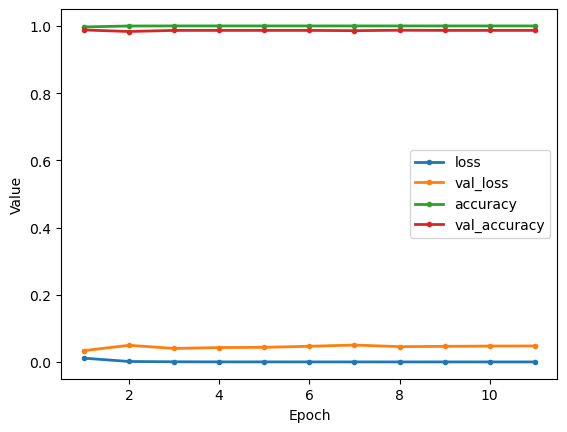

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/95 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step

 5/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  

 9/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

13/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

17/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

21/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

25/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

33/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

37/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

41/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

45/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

49/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

53/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

57/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

61/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

65/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

69/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

74/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

78/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

81/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

88/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

92/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


 1/95 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step

 5/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  

 9/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

13/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

17/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

21/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

25/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

33/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

37/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

41/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

45/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

49/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

53/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

57/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

61/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

65/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

69/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

73/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

77/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

81/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

93/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/M-type_MADS/report_15H6QLJO.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################